# EDA
In this notebook, I'll take a look at the data and create basic visualizations.

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import seaborn as sns

import pickle
from SCRIPT.eval_tools import *


In [36]:
with open('PKL/timeseries_queens_p.pkl', 'rb') as fp:
    df = pickle.load(fp)

In [37]:
with open('PKL/timeseries_queens.pkl', 'rb') as fp:
    df_price = pickle.load(fp)

In [38]:
df.head(2)

,11375,11377,11355,11385,11373,11372,11101,11368,11354,11374,...,11411,11426,11428,11693,11004,11416,11436,11366,11363,11430
10/2003,0.641106,0.025764,0.617861,1.445379,0.911887,1.087976,-0.519150,0.773631,0.222411,1.472281,...,0.972774,0.804183,0.577941,-0.282295,0.766544,0.684947,0.962143,0.885990,-1.010606,0.730116
11/2003,0.913096,0.023655,0.541069,1.059983,0.795460,0.937562,-0.729033,1.045561,0.319332,1.109527,...,0.805483,0.607796,0.611333,0.361882,0.651715,0.512377,0.229578,0.975936,-0.293376,0.554509


## Train/Test Split

In [70]:
trdf = df.iloc[:-40]
trdf.index = pd.to_datetime(trdf.index)

In [71]:
trdf_price = df_price.iloc[:-40]
trdf_price.index = pd.to_datetime(trdf_price.index)

## Average Values of Homes
Let's see what's the average values of homes in Queens in general.

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


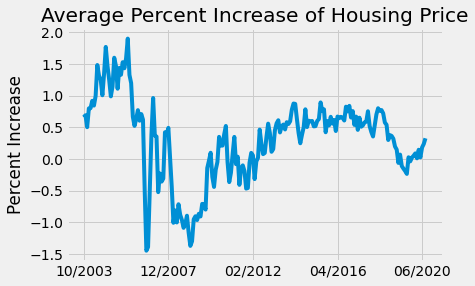

In [65]:
mean = np.mean(df, axis = 1)
ax = mean.plot(figsize = (6, 4))
plt.ylabel('Percent Increase')
plt.title('Average Percent Increase of Housing Price')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


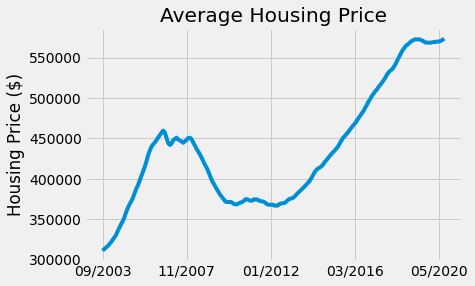

In [66]:
price_mean = np.mean(df_price, axis = 1)
ax = price_mean.plot(figsize = (6, 4))
plt.ylabel('Housing Price ($)')
plt.title('Average Housing Price')
plt.show()

We can see that the price increase dropped around the 2007 recession and unstable for a few years, then the price increase start to climb up. Recently the increase rate might have been start to stabilize. 

In [67]:
tmp = df.copy()
tmp.index = tmp.index.strftime('%Y')

fig = plt.figure(figsize = (10, 4))
ax = sns.heatmap(tmp.T, robust = True, cmap = 'Spectral_r', 
           yticklabels = False, xticklabels = 16)

plt.show()

AttributeError: 'Index' object has no attribute 'strftime'

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


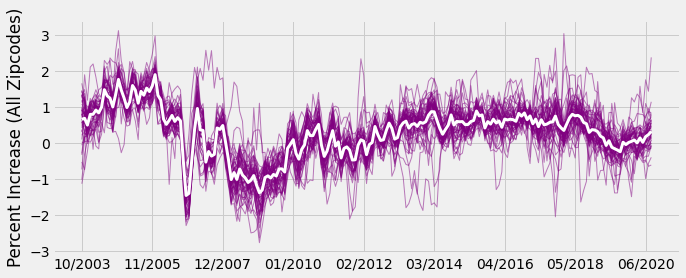

In [68]:
df.plot(figsize = (10, 4), lw = 1, color = 'purple', alpha = 0.5)
mean.plot(c = 'white', lw = 3)
plt.legend().set_visible(False)
plt.ylabel('Percent Increase (All Zipcodes)')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


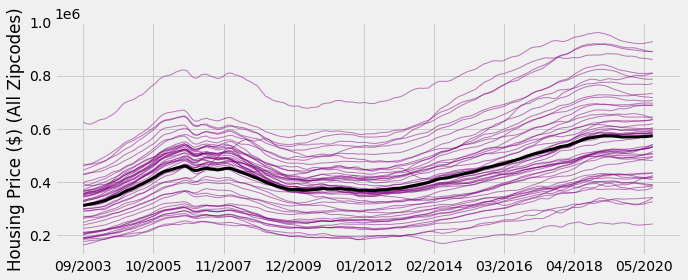

In [69]:
df_price.plot(figsize = (10, 4), lw = 1, color = 'purple', alpha = 0.5)
price_mean.plot(c = 'black', lw = 3)
plt.legend().set_visible(False)
plt.ylabel('Housing Price ($) (All Zipcodes)')
plt.show()

We can see that most neighborhoods in the queens tend to have pretty similar shift in percentage changes, but there are definitely handful of outliers (e.g. LIC) that went against the trend. Let's try to plot couple locations that's furthest away from the average line.

## Areas Against the Trend

In [52]:
# calculate absolute difference
diff_df = trdf.apply(lambda x: abs(x-mean))

In [53]:
# add up
diffs = np.sum(diff_df, axis = 0).sort_values(ascending = False)
select_zipcodes = list(diffs.index[0:5])
print(f'top 5 zipcodes with odd trends: {select_zipcodes}')


top 5 zipcodes with odd trends: [11693, 11101, 11692, 11694, 11103]


In [54]:
print(f'closest to the average: {diffs.index[-1]}')

closest to the average: 11432


Mapping the odd locations

In [55]:
diffdf = pd.DataFrame(diffs, columns = ['diff'])
diffdf = diffdf.reset_index()
diffdf = diffdf.rename(columns = {'index': 'zip'})
diffdf['zip'] = diffdf['zip'].astype('str')

Loading GeoJSON

In [56]:
geodata_sel = select_geodata(diffdf['zip'].values)

In [57]:
plot_coropleth(diffdf, ['zip', 'diff'], 
               'Absolute Deviation from Average', geodata_sel)

It seems like the LIC and the Rockaway beach area tend to have different trend compared to overall average.

## Total Percent Increase
Now let's look at the total percent increase in all neighborhoods between 10/2003 to 03/2017

In [58]:
sumdf = pd.DataFrame(trdf.sum(), columns = ['sum'])
sumdf = sumdf.reset_index()
sumdf = sumdf.rename(columns = {'index': 'zip'})
sumdf['zip'] = sumdf['zip'].astype('str')

In [59]:
plot_coropleth(sumdf, ['zip', 'sum'], 
               'Total Percent Increase', geodata_sel)

Overall areas closer to Manhattan did show more total percent increase with a fewer exception (e.g. nearing airport)

## Median Increase
Now let's look at each neighborhood's median percent increase.

In [60]:
mediandf = pd.DataFrame(trdf.median(), columns = ['median'])
mediandf = mediandf.reset_index()
mediandf = mediandf.rename(columns = {'index': 'zip'})
mediandf['zip'] = mediandf['zip'].astype('str')

In [61]:
plot_coropleth(mediandf, ['zip', 'median'], 
               'Median Percent Increase', geodata_sel)

Generally all neighborhoods had an upward trend at all time.

## Average Housing Price Past 10 years

In [84]:
meandf = pd.DataFrame(df_price['08/2010':'08/2020'].mean(), columns = ['mean'])
meandf = meandf.reset_index()
meandf = meandf.rename(columns = {'index': 'zip'})
meandf['zip'] = meandf['zip'].astype('str')

In [85]:
plot_coropleth(meandf, ['zip', 'mean'], 
               'Average Housing Price', geodata_sel)

## Growth Past 10 years

In [91]:
min_max = df_price.loc['08/2020'] - df_price.loc['08/2010']

In [92]:
minmaxdf = pd.DataFrame(min_max, columns = ['diff'])
minmaxdf = minmaxdf.reset_index()
minmaxdf = minmaxdf.rename(columns = {'index': 'zip'})
minmaxdf['zip'] = minmaxdf['zip'].astype('str')

In [93]:
plot_coropleth(minmaxdf, ['zip', 'diff'], 
               'Price Growth in 10 Years', geodata_sel)

## Select Zipcode
For the initial univariate modeling, I will compare the top 5 zipcodes with the highest deviation from the average and one zipcode closest to the average. 

In [20]:
select_zipcodes = [11101, 11693, 11692, 11694, 11103]